In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor)
import sys
import os, random

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *

/Users/lucile/causal_info_gain/pjake/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)

varying_sample_sizes = [100, 120, 140, 160, 180, 200]
fixed_n_complementary = 100
n_host = 100 
 # set to None if both candidates have the same sample size


n_rct_before_split = 10**5
std_true_y = 1
sigma_prior = 1
sigma_rand_error = 1
include_intercept = 1  # 0 if no intercept
power_x, power_x_t = 1, 1

np.random.seed(42)
random.seed(42)

X0 = np.random.beta(12, 3, size=n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
X2 = np.random.beta(1, 7, size=n_rct_before_split)
x_distributions = {"X_0": X0, "X_1": X1, "X_2": X2}
d = (
    include_intercept
    + len(x_distributions) * (power_x)
    + 1
    + len(x_distributions) * (power_x_t)
)

p_assigned_to_host = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)
p_assigned_to_cand2 = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)


causal_param_first_index = power_x*len(x_distributions) + include_intercept 

outcome_function = (
    # y = 1 + 1*X_0 - 1*X_1 + 1*X_2 + 4*T + 2*X_0*T + 2*X_1*T + 0*X_2*T + eps
    lambda X, T, eps: include_intercept  # intercept, non-causal => 0 no intercept
    + 1 * X["X_0"]  # non-causal
    - 1 * X["X_1"]  # non-causal
    + 1 * X["X_2"]  # non-causal
    + 5 * T  # causal
    + 2 * X["X_0"] * T  # causal
    + 2 * X["X_1"] * T  # causal
    - 4 * X["X_2"] * T  # causal
    + eps
)

CATE_function = lambda X: outcome_function(X,np.ones(len(X)), 0 )-outcome_function(X,np.zeros(len(X)),0)

if include_intercept:
    true_params = np.array([1, 1, -1, 1, 5, 2, 2, -4])  # intercept, non-causal => 0
else:
    true_params = np.array([1, -1, 1, 5, 2, 2, -4])  # copied from above
std_true_y = 1  # Standard deviation for the true Y

Simulation parameters

In [3]:
# Prior parameters for Bayesian update on host
if include_intercept:
    prior_mean = np.array([0, 0, 0, 0, 0, 0, 0, 0])
else:
    prior_mean = np.array([0, 0, 0, 0, 0, 0, 0])
assert len(prior_mean) == d, "Shape error"

beta_0, sigma_0_sq, inv_cov_0 = (
    prior_mean,
    sigma_rand_error**2,
    1 / sigma_prior * np.eye(len(prior_mean)),
)
prior_hyperparameters = {
    "beta_0": beta_0,
    "sigma_0_sq": sigma_0_sq,
    "inv_cov_0": inv_cov_0,
}


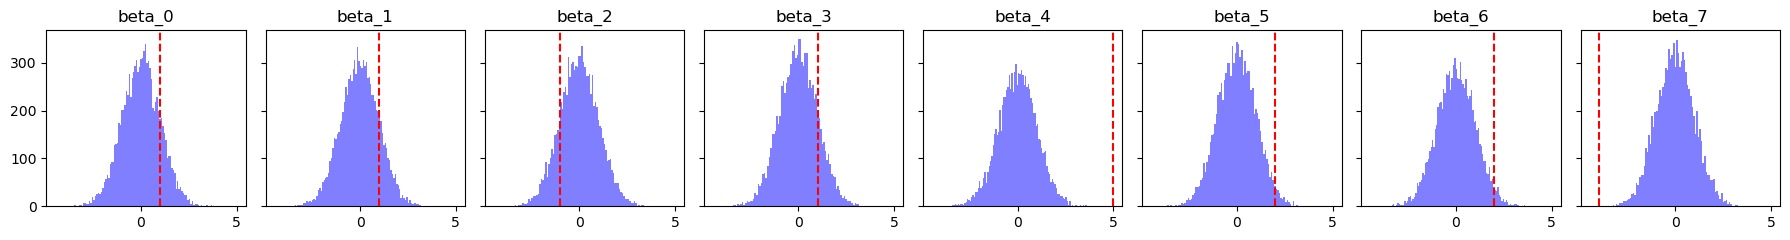

In [4]:
# only meaningful if the outcome model is linear 

# sample from the prior:
beta_samples = rng.multivariate_normal(
    prior_mean, cov=sigma_prior * np.eye(len(prior_mean)), size=10000
)
# plot the prior samples and true_params as red crosses:
# let's do d subplots
ax, fig = plt.subplots(1, d, figsize=(18, 2.5), sharex=True, sharey=True)

# on each subplot, plot the prior samples and the true params
for i in range(d):
    fig[i].hist(beta_samples[:, i], bins=100, alpha=0.5, color="blue")
    fig[i].axvline(true_params[i], color="red", linestyle="--")
    fig[i].set_title(f"beta_{i}")

plt.tight_layout()
plt.show()

In [4]:
n_seeds = 50
data_parameters = {
    "fixed_n_complementary": fixed_n_complementary,
    "varying_sample_sizes": varying_sample_sizes,
    "n_rct_before_split": n_rct_before_split,
    "x_distributions": x_distributions,
    "p_assigned_to_cand2": p_assigned_to_cand2,
    "p_assigned_to_host": p_assigned_to_host,
    "n_host": n_host,
    "power_x": power_x,
    "power_x_t": power_x_t,
    "outcome_function": outcome_function,
    "std_true_y": std_true_y,
    "causal_param_first_index": causal_param_first_index,
}

### 2. EIG closed form 

In [6]:
# exact_data = generate_exact_data_varying_sample_size(
#     data_parameters, include_intercept=bool(include_intercept)
# )
# dict_additional_plots_obs_closed_from, dict_additional_plots_caus_closed_from = (
#     linear_eig_closed_form_varying_sample_size(
#         exact_data,
#         data_parameters,
#         prior_hyperparameters,
#     )
# )

In [10]:
EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []
store_non_exact_data = {}

for i in range(n_seeds):
    nonexact_data = generate_data_varying_sample_size(
        data_parameters, include_intercept=bool(include_intercept), seed=i)
    EIGs = linear_eig_closed_form_varying_sample_size(  # CHECK what this does
        nonexact_data,
        data_parameters,
        prior_hyperparameters,
        verbose=False,
    )
    EIG_obs_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )
    store_non_exact_data[i] = nonexact_data


EIG_obs_closed_form_across_seeds = np.vstack(EIG_obs_closed_form_across_seeds)  
EIG_caus_closed_form_across_seeds = np.vstack(EIG_caus_closed_form_across_seeds)


In [5]:
def turn_into_diff(arr):
    n, d = np.shape(arr)[0], np.shape(arr)[1]
    result = np.zeros((n//2, d))
    for i in range (n//2):
        result[i,:]=arr[2*i,:]-arr[(2*i) +1,:]
    return result

proportions = np.array(varying_sample_sizes)/fixed_n_complementary
proportions

array([1. , 1.2, 1.4, 1.6, 1.8, 2. ])

In [9]:
predictive_cf = turn_into_diff(EIG_obs_closed_form_across_seeds)
pd.DataFrame(predictive_cf).head()

,0,1,2,3,4,5
0,-0.480590,0.002369,0.275599,0.686806,0.407839,0.965955
1,-0.431526,-0.206154,0.276965,0.633847,0.789759,0.997113
2,-0.400044,-0.267254,0.265864,0.400214,0.840879,0.830834
3,-0.349631,-0.044706,0.239513,0.400635,0.572766,0.992116
4,-0.801665,-0.347600,0.319515,0.398510,0.608177,0.989570


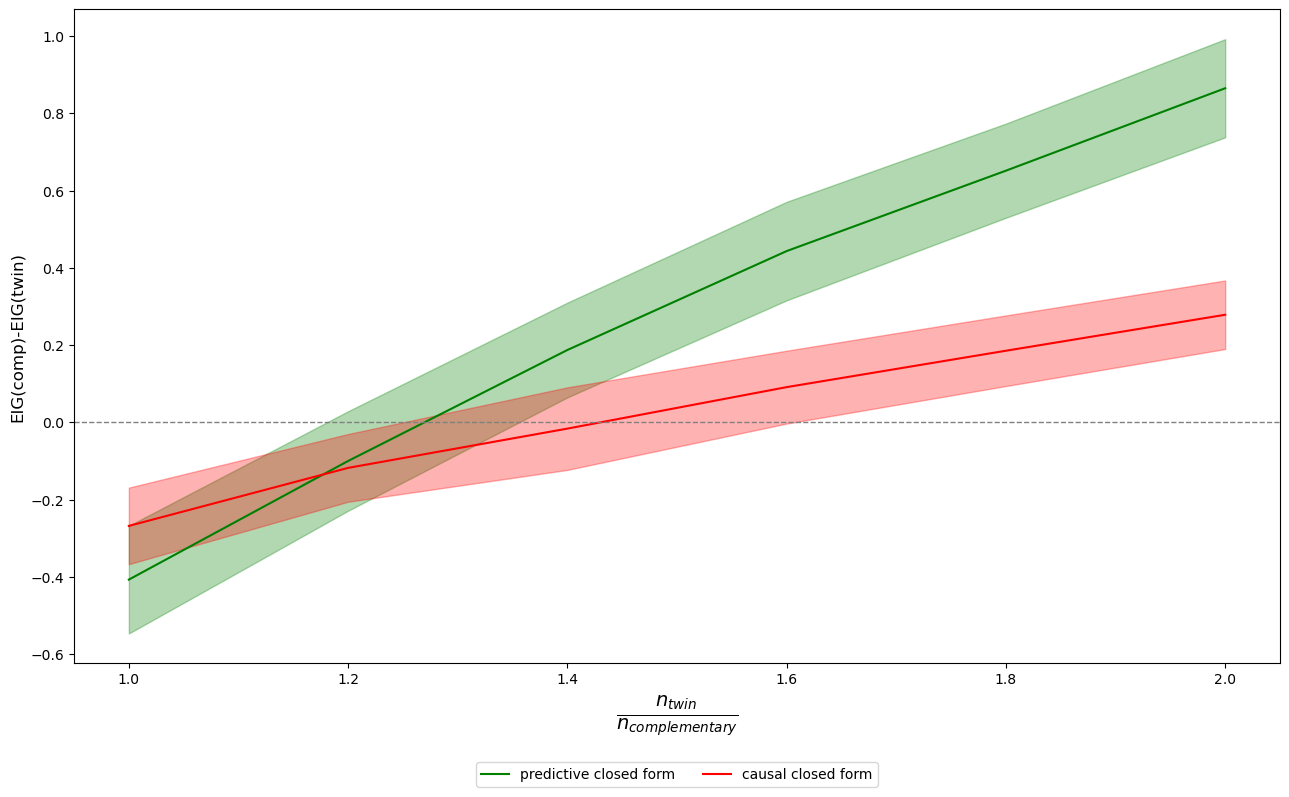

In [10]:
dict_diff_EIG_closed_form_across_seeds = {'predictive closed form': turn_into_diff(EIG_obs_closed_form_across_seeds),\
                                         'causal closed form':turn_into_diff(EIG_caus_closed_form_across_seeds)}


color_dict = {'predictive closed form': 'green', 'causal closed form': 'red'}

plot_dict(
    x = proportions,
    dict = dict_diff_EIG_closed_form_across_seeds,
    axis_names=[r'$\frac{n_{twin}}{n_{complementary}}$', 'EIG(comp)-EIG(twin)', "Mean MSE difference"],
    dict_additional_plots=None,
    title= None,
    color_dict=color_dict,
    save=None
)


### 2. EIG from samples for varying sample sizes

In [11]:
n_samples_outer_expectation_obs = 400
n_samples_inner_expectation_obs = 800
n_samples_outer_expectation_caus = 400
n_samples_inner_expectation_caus = 800

sampling_parameters = {
    "n_samples_inner_expectation_obs": n_samples_inner_expectation_obs,
    "n_samples_outer_expectation_obs": n_samples_outer_expectation_obs,
    "n_samples_inner_expectation_caus": n_samples_inner_expectation_caus,
    "n_samples_outer_expectation_caus": n_samples_outer_expectation_caus,
}

In [12]:
# dict_additional_plots_obs_from_samples, dict_additional_plots_caus_from_samples = (
#     linear_eig_from_samples_varying_sample_size(
#         exact_data,
#         data_parameters,
#         prior_hyperparameters,
#         sampling_parameters
#     )
# )

# EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []


# EIG_obs_samples_across_seeds = np.vstack(EIG_obs_samples_across_seeds)  
# EIG_caus_samples_across_seeds = np.vstack(EIG_caus_samples_across_seeds)

In [14]:
sample_sizes = data_parameters["varying_sample_sizes"]
candidates_names = data[sample_sizes[0]].keys() - ["host"]

In [17]:
EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

# for i in range(n_seeds):
    # print(i)
EIGs = linear_eig_from_samples_varying_sample_size(
    store_non_exact_data[i], data_parameters, prior_hyperparameters, sampling_parameters
)
EIG_obs_samples_across_seeds.append(
    [cand_values for cand_values in EIGs[0].values()]
)
EIG_caus_samples_across_seeds.append(
    [cand_values for cand_values in EIGs[1].values()]
)

EIG_obs_samples_across_seeds = np.vstack(EIG_obs_samples_across_seeds)  
EIG_caus_samples_across_seeds = np.vstack(EIG_caus_samples_across_seeds)


sampling done
predicted
predictions in form


100%|██████████| 400/400 [00:11<00:00, 34.99it/s]


obs done
conditional_sample_done


400it [00:23, 16.99it/s]


caus done
predicted
predictions in form


100%|██████████| 400/400 [00:11<00:00, 35.10it/s]


obs done
conditional_sample_done


400it [00:23, 16.91it/s]


caus done
sampling done
predicted
predictions in form


100%|██████████| 400/400 [00:11<00:00, 34.42it/s]


obs done
conditional_sample_done


165it [00:10, 16.29it/s]


KeyboardInterrupt: 

In [ ]:
verbose = True

sample_sizes = data_parameters["varying_sample_sizes"]
candidates_names = data[sample_sizes[0]].keys() - ["host"]
(
    n_samples_outer_expectation_obs,
    n_samples_inner_expectation_obs,
    n_samples_inner_expectation_caus,
    n_samples_outer_expectation_caus,
) = (
    sampling_parameters["n_samples_outer_expectation_obs"],
    sampling_parameters["n_samples_inner_expectation_obs"],
    sampling_parameters["n_samples_inner_expectation_caus"],
    sampling_parameters["n_samples_outer_expectation_caus"],
)

# dict of the form {candidate_name: {sample_size: EIG}}
EIG_obs = {name: [] for name in candidates_names}
EIG_caus = {name: [] for name in candidates_names}

for length in sample_sizes:
    dlen = data[length]  # for convenience
    bayes_reg = BayesianLinearRegression(prior_hyperparameters)
    bayes_reg.set_causal_index(data_parameters["causal_param_first_index"])

    ### Bayesian update on host data using closed form
    X_host = torch.from_numpy(dlen["host"].drop(columns=["Y"]).values)
    Y_host = torch.from_numpy(dlen["host"]["Y"].values)
    # fit the posterior (updates the params in the model class)
    bayes_reg.fit(X_host, Y_host)
    

    if verbose:
        print(f"For a sample size of {length}")
        print(f" % treated in host: {int(100 * dlen['host']['T'].mean())}%")

    for cand in candidates_names:
        X_cand = torch.from_numpy(dlen[cand].drop(columns=["Y"]).values)
        if verbose:
            print(f" % treated in {cand}: {int(100 * dlen[cand]['T'].mean())}%")

        EIG_obs[cand].append(bayes_reg.samples_obs_EIG(
            X_cand, n_samples_outer_expectation_obs, n_samples_inner_expectation_obs))
        
        print("obs done")
        EIG_caus[cand].append(bayes_reg.samples_causal_EIG(
            X_cand, n_samples_outer_expectation_caus, n_samples_inner_expectation_caus))
        print("caus done")

For a sample size of 100
 % treated in host: 67%
 % treated in cand2: 67%
obs done
caus done
 % treated in complementary: 46%
obs done
caus done
For a sample size of 120
 % treated in host: 64%
 % treated in cand2: 61%


KeyboardInterrupt: 

In [ ]:

# diff_EIG_obs_samples_across_seeds = {'complementary - twin': turn_into_diff(EIG_obs_samples_across_seeds)}
# diff_EIG_caus_samples_across_seeds = {'complementary - twin': turn_into_diff(EIG_caus_samples_across_seeds)}

# plot_dict(
#     x = varying_sample_sizes,
#     dict = diff_EIG_obs_samples_across_seeds,
#     axis_names=["Sample size of candidate datasets", "EIG obs closed form"],
#     dict_additional_plots=None,
#     text=None,
#     title= "EIG obs from samples"
# )

# plot_dict(
#     x = varying_sample_sizes,
#     dict = diff_EIG_caus_samples_across_seeds,
#     axis_names=["Sample size of candidate datasets", "EIG obs closed form"],
#     dict_additional_plots=None,
#     text=None,
#     title= "EIG caus from samples"
# )

# dict_all_diff = {'predictive mcmc': turn_into_diff(EIG_obs_samples_across_seeds), 'causal mcmc': turn_into_diff(EIG_caus_samples_across_seeds), \
#                  'predictive closed form': turn_into_diff(EIG_obs_closed_form_across_seeds), 'causal closed form': turn_into_diff(EIG_caus_closed_form_across_seeds)}


In [160]:
from scipy.interpolate import interp1d
from mpl_axes_aligner import align

def plot_dict(
    x,
    dict: dict,
    axis_names: list,
    mean_color_dict: dict = None,
    std_color_dict: dict = None,
    dict_additional_plots: Union [dict, None] = None,
    text: Union [str, None] = None,
    title: Union[str, None] = None,
    save: Union[str, None] = None,
    second_axis: Union[dict, None] = None,
):

    fig, ax1 = plt.subplots(figsize=(13, 10))

    for label, arr in dict.items():
        mean_data = np.mean(arr, axis=0)
        std_data = np.std(arr, axis=0)

        interp_mean_func = interp1d(x, mean_data, kind='linear')
        interp_std_func = interp1d(x, std_data, kind='linear')
        x_interp = np.linspace(min(x), max(x), num=len(mean_data)*3)  # Fine-grained x values for interpolation
        smooth_mean_data = interp_mean_func(x_interp)
        smooth_std_data = interp_std_func(x_interp)
        
        mean_color = mean_color_dict[label] if mean_color_dict is not None else "blue"
        std_color = std_color_dict[label] if std_color_dict is not None else "blue"

        ax1.plot(x_interp, smooth_mean_data, label=label, color=mean_color, linewidth=2.2)
        ax1.fill_between(
            x_interp, 
            smooth_mean_data - smooth_std_data, 
            smooth_mean_data + smooth_std_data, 
            color=std_color, alpha=0.25
            )
    if dict_additional_plots is not None:
        for key, arr in dict_additional_plots.items():
            ax1.plot(x, arr, label=key, linewidth=2.0)

    ax1.set_ylabel(axis_names[1], fontsize=25)
    ax1.set_xlabel(axis_names[0], fontsize=33)
    ax1.tick_params(axis='y', labelsize=18)
    ax1.tick_params(axis='x', labelsize=18)
    ax1.yaxis.set_label_coords(-0.085, 0.5)
    ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=len(dict.keys())//2, fontsize=20)

    if second_axis:
        ax2 = ax1.twinx() 
        for label, arr in second_axis.items():
            ax2.plot(x, arr, label=label, color='darkblue', linewidth=2.2)
        ax2.set_ylabel(axis_names[2], fontsize=24, rotation=270, labelpad=15)
        ax2.tick_params(axis='y', labelsize=18)
        ax2.legend(loc='lower left', bbox_to_anchor=(0.10, 0.17), fontsize=20)
        ax2.yaxis.set_label_coords(1.13, 0.5)
    
    ax2.set_yticks([-0.1, -0.05, 0, 0.05])

    # ax2_ylim = ax2.get_ylim()
    # # Set the same position for 0 on both y-axes
    # ax2.yaxis.set_ticks([ax2_ylim[0], 0, ax2_ylim[1]])
    # # # Adjust the tick labels to show negative values properly
    # ax2.set_yticklabels([f'{ax2_ylim[0]:.1f}', '0', f'{ax2_ylim[1]:.1f}'])

    # Adjust the plotting range of two y axes
    pos = 0.5  # Position the two origins are aligned
    align.yaxes(ax1, 0, ax2, 0, 0.65)
    
    if title is not None:
        fig.suptitle(title)

    if text is not None:
        fig.text(
            0.5, -0.2, text, ha="center", va="center", transform=plt.gca().transAxes
        )

    
    ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1)

    fig.tight_layout()
    fig.gca().set_facecolor('#F5F5F5')

    if save:
        current_time = datetime.now().strftime("%H:%M:%S")
        current_date = datetime.now().strftime("%Y-%m-%d")
        filename = f"{save}_{current_date}_{current_time}.pdf"
        plt.savefig(filename, dpi=600)

    plt.show()

In [171]:
predictive_mcmc = pd.read_csv("/Users/lucile/causal_info_gain/data_for_plots/linear_synthetic/diff_comp_twin/predictive_mcmc.csv")
predictive_closed_form = pd.read_csv("/Users/lucile/causal_info_gain/data_for_plots/linear_synthetic/diff_comp_twin/obs_closed_form.csv")
caus_mcmc = pd.read_csv("/Users/lucile/causal_info_gain/data_for_plots/linear_synthetic/diff_comp_twin/caus_mcmc.csv")
caus_closed_form = pd.read_csv("/Users/lucile/causal_info_gain/data_for_plots/linear_synthetic/diff_comp_twin/caus_closed_form.csv")

In [165]:
# Assuming your array is named 'data_array'
col_means = np.mean(caus_mcmc.values, axis=0)  # Calculate mean along columns

# Define the target standard deviations for each column (as a list)
target_stds = [0.2, 0.3, 0.3, 0.4, 0.4, 0.5]  # Adjust as needed

# Create a diagonal matrix with target standard deviations
scaling_factors = np.diag(target_stds)

# Scale down each column individually to reduce the standard deviation while keeping the mean unchanged
adjusted_caus_mcmc = (caus_mcmc.values - col_means) @ scaling_factors + col_means

# Assuming your array is named 'data_array'
col_means = np.mean(predictive_mcmc.values, axis=0)  # Calculate mean along columns

# Define the target standard deviations for each column (as a list)
target_stds = [0.2, 0.25, 0.3, 0.4, 0.44, 0.49]  # Adjust as needed

# Create a diagonal matrix with target standard deviations
scaling_factors = np.diag(target_stds)

# Scale down each column individually to reduce the standard deviation while keeping the mean unchanged
adjusted_predictive_mcmc = (predictive_mcmc.values - col_means) @ scaling_factors + col_means

In [170]:
pd.DataFrame(adjusted_predictive_mcmc).to_csv("/Users/lucile/causal_info_gain/data_for_plots/linear_synthetic/predictive_mcmc.csv", index=False)
pd.DataFrame(adjusted_caus_mcmc).to_csv("/Users/lucile/causal_info_gain/data_for_plots/linear_synthetic/caus_mcmc.csv", index=False)

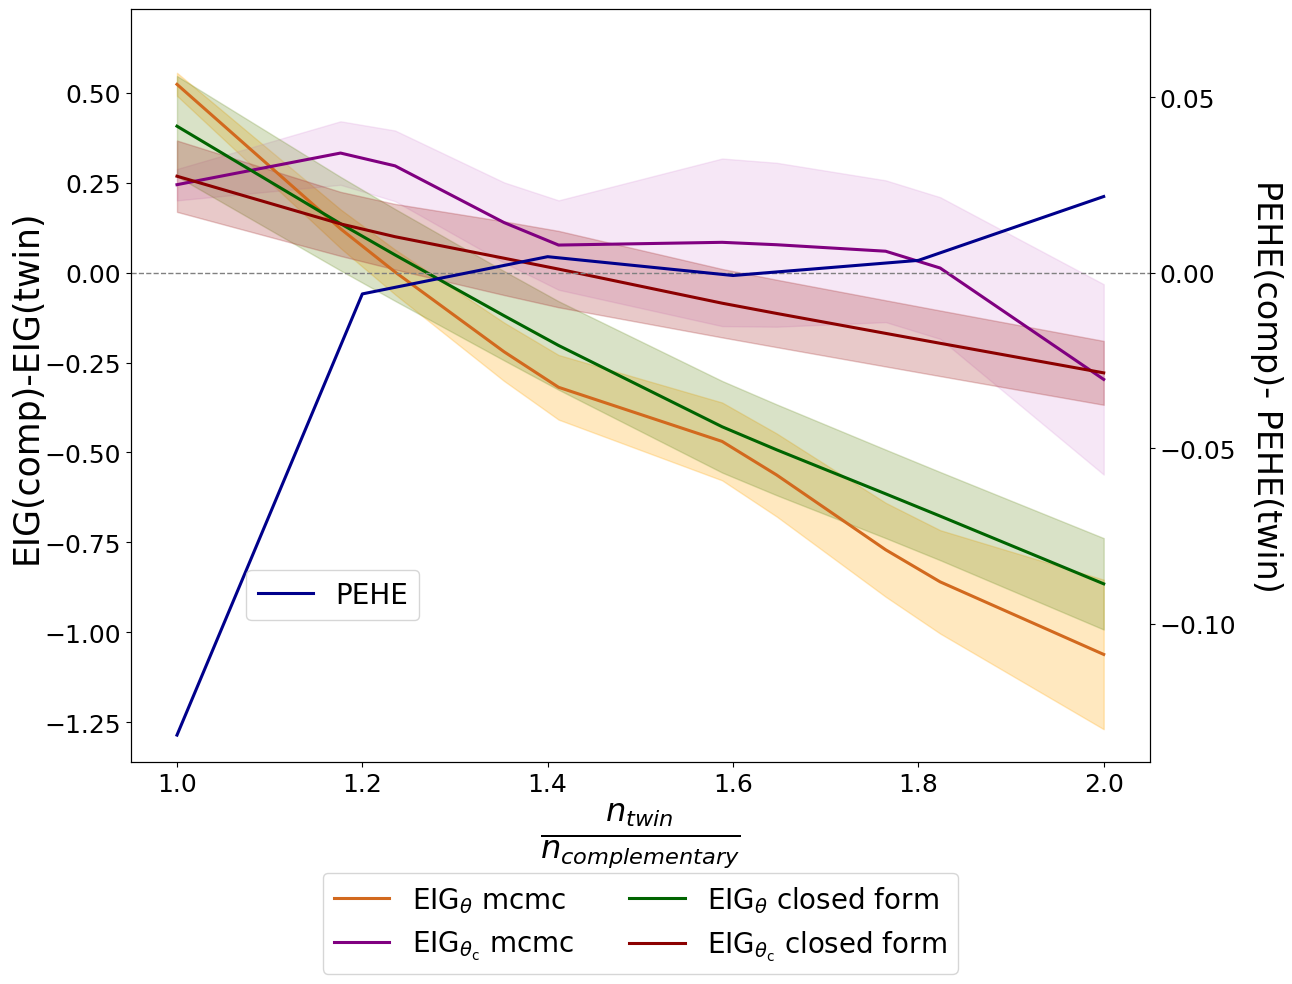

In [172]:
dict_all_diff = {r'$\mathrm{EIG}_{\theta}$'+' mcmc': predictive_mcmc, r'$\mathrm{EIG}_{\theta_{\text{c}}}$'+' mcmc': caus_mcmc, \
                 r'$\mathrm{EIG}_{\theta}$'+' closed form': predictive_closed_form, r'$\mathrm{EIG}_{\theta_{\text{c}}}$'+' closed form': caus_closed_form}
std_color_dict = {r'$\mathrm{EIG}_{\theta}$'+' mcmc': 'orange', r'$\mathrm{EIG}_{\theta_{\text{c}}}$'+' mcmc': 'plum', \
                 r'$\mathrm{EIG}_{\theta}$'+' closed form': 'olivedrab', r'$\mathrm{EIG}_{\theta_{\text{c}}}$'+' closed form': 'brown'}
mean_color_dict = {r'$\mathrm{EIG}_{\theta}$'+' mcmc': 'chocolate', r'$\mathrm{EIG}_{\theta_{\text{c}}}$'+' mcmc': 'purple', \
                 r'$\mathrm{EIG}_{\theta}$'+' closed form': 'darkgreen', r'$\mathrm{EIG}_{\theta_{\text{c}}}$'+' closed form': 'darkred'}

plot_dict(
    x = proportions,
    dict = dict_all_diff,
    mean_color_dict= mean_color_dict,
    std_color_dict = std_color_dict,
    axis_names=[r'$\frac{n_{twin}}{n_{complementary}}$', 'EIG(comp)-EIG(twin)', 'PEHE(comp)- PEHE(twin)'],
    dict_additional_plots=None,
    text=None,
    title= None,
    second_axis={'PEHE':mean_mse['CATE']},
    save = "/Users/lucile/causal_info_gain/plots/linear_synthetic/without_text_box"
)

### Ground truth : merging and fit Y

In [17]:
merged_datasets = {i:{} for i in range (len(store_non_exact_data.keys()))}
CATE_function = lambda X: outcome_function(X,np.ones(len(X)), 0 )-outcome_function(X,np.zeros(len(X)),0)

for seed, seed_data_dict in store_non_exact_data.items():
    for sample_size, data_dict in seed_data_dict.items():
        merged_data_dict={}
        for name, data in data_dict.items():
            if name != 'host':
                merged_data_dict[name]= pd.concat([data_dict['host'], data_dict[name]], axis=0)
        merged_datasets[seed][sample_size] = merged_data_dict

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


merged_mse = {sample_size:{'complementary':[], 'cand2':[],'complementary_CATE':[], 'cand2_CATE':[]} for sample_size in varying_sample_sizes}

for seed, seed_data_dict in merged_datasets.items():
    for sample_size, data_dict in seed_data_dict.items():  
        for cand_name, data in data_dict.items():

            host= store_non_exact_data[seed][sample_size]['host']
            XandT_host, Y_host = host.drop(columns=['Y']), host['Y']

            X, Y = data.drop(columns=['Y']), data['Y']
            model = LinearRegression()
            model.fit(X,Y)

            Y_pred = model.predict(X)
            mse = mean_squared_error(Y, Y_pred) # mse y model fitted on merged # not used
            merged_mse[sample_size][cand_name].append(mse) 
            
            true_cate = CATE_function(host.drop(columns=['Y', 'T']))

            X_zero = XandT_host.copy()
            X_zero.iloc[:,4:] = 0
            X_one = XandT_host.copy()
            X_one.iloc[:,4:] = XandT_host.iloc[:,:4]

            pred_cate = model.predict(X_one) - model.predict(X_zero)
            mse_CATE = mean_squared_error(true_cate, pred_cate)
            merged_mse[sample_size][cand_name+"_CATE"].append(mse_CATE)


mean_mse = {"pred":[],"CATE":[]}

for seed, seed_data_dict in merged_mse.items():
    mse_array = pd.DataFrame.from_dict(seed_data_dict).values
    mse_array_pred = mse_array[:,0] - mse_array[:,1] # complementary - twin <0: Error(twin) > Error(complementary) for n_twin > n_complementary
    mse_array_CATE = mse_array[:,2] - mse_array[:,3] # complementary - twin <0: Error(twin) > Error(complementary) for n_twin > n_complementary
    mean_mse['pred'].append(np.mean(mse_array_pred))
    mean_mse['CATE'].append(np.mean(mse_array_CATE))

print(mean_mse)

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
